# DBSCAN

In [1]:
from sklearn.datasets.samples_generator import make_blobs, make_moons
from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
blobs_X, blobs_y = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=2, random_state=42)
blobs_X[:5]

array([[-8.57321463, -9.90980404],
       [ 6.26691327, -0.48855895],
       [-3.44814639, 10.09940622],
       [ 7.44546746, -0.83053244],
       [-6.16405247, -5.75854054]])

In [3]:
# y - настоящая метка, или какому blob она принадлежит
blobs_y[:5]

array([2, 1, 0, 1, 2])

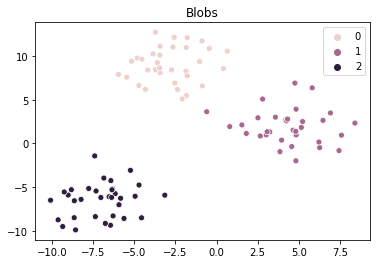

In [4]:
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=blobs_y)
plt.title("Blobs")
plt.show()

# Реализация DBSCAN в SKlearn

In [5]:
from sklearn.cluster import DBSCAN

In [6]:
%%time
# eps расстояние до соседей
# min_samples это количество соседей, необходимое для того, чтобы быть основной точкой
sklearn_clusters = DBSCAN(eps=2, min_samples=5).fit(blobs_X)

Wall time: 2 ms


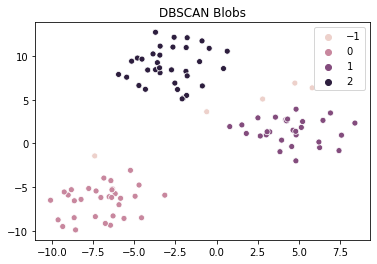

In [7]:
# Тот же график, что и раньше, но с метками DBSCAN SKlearn
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=sklearn_clusters.labels_)
plt.title("DBSCAN Blobs")
plt.show()

# Написание собственной реализации

In [8]:
import math

# Я буду использовать функцию расстояния по умолчанию - евклидово расстояние
def EuclideanDistance(point1, point2):
  """ 
   Возвращает евклидово расстояние между двумя точками.
  
   Предполагает, что точки представляют собой список значений координат, работает с любым количеством измерений.
  """
  sum = 0
  for i in range(len(point1)):
    sum += (point2[i] - point1[i]) ** 2
  return math.sqrt(sum)

In [9]:
# DBSCAN использует вспомогательную функцию, которая возвращает все точки на определенном расстоянии от данной точки.
def RangeQuery(collection, point, distFunc, eps):
  """
   Находит все точки в коллекции на расстоянии eps от точки.

   Возвращает список значений индекса, указывающих эти точки в коллекции.

   Аргументы:
     collection (iterable): список точек
     point (iterable): точка, представленная в виде списка координат
     distFunc (callable): функция расстояния для использования
     eps (float): epsilon, максимальное расстояние для включения точек
  """
  neighbors = []
  for i in range(len(collection)):
    if distFunc(collection[i], point) < eps:
      neighbors.append(i)
  
  return neighbors

In [10]:
# Основная функция DBSCAN
def my_DBSCAN(X, eps, minPts, distFunc="euclidean"):
  """
  Кластеризация на основе плотности возвращает список меток, назначающих каждую точку кластеру. 
  Кластеры будут помечены как 0 и выше, а точки выбросов будут помечены как -1.

  Аргументы:
    X (iterable): набор точек

    eps (float): epsilon, расстояние для точек, которые считаются близкими друг к другу

    minPts (int): количество точек, которые должны быть в пределах эпсилон-расстояния, чтобы точка считалась основной точкой

    distFunc (callable): используемая функция расстояния, по умолчанию используется евклидово расстояние
  """
  if distFunc == "euclidean":
    distFunc = EuclideanDistance

  labels = [None] * len(X)  # начать со всех меток undefined
  cluster = 0  # cluster counter

  for i in range(len(X)):
    if labels[i] is not None:
      # Эта точка уже найдена как сосед, пропустите ее
      continue
    
    # Найти все точки на расстоянии eps до этой точки
    neighbors = RangeQuery(X, X[i], distFunc, eps)

    if len(neighbors) < minPts:
      # недостаточно connected points, i не является основной точкой
      labels[i] = -1
      continue
    
    # эта точка находится в кластере
    labels[i] = cluster

    # так как i центральная точка, все соседи находятся в этом кластере
    # найти этих соседей, и, если они также являются ключевыми точками, добавить их соседей
    j = 0
    while j < len(neighbors):
      p = neighbors[j]  # получить индекс этой точки
      if labels[p] == -1:
        # назначить выброс этому кластеру (граничная точка)
        labels[p] = cluster
      
      if labels[p] is not None:
        # точка уже найдена, пропустите ее
        j += 1
        continue
      
      # назначить эту точку кластеру и найти его соседей
      labels[p] = cluster
      new_neighbors = RangeQuery(X, X[p], distFunc, eps)
      if len(new_neighbors) >= minPts:
        # j также является центральной точкой, добавьте его соседей в список для рассмотрения
        # добавляем каждого соседа, которого еще нет в списке, сохраняем порядок в списке
        for n in new_neighbors:
          if n not in neighbors:
            neighbors.append(n)
      
      j += 1  # перейти к следующей точке
    
    cluster += 1  # увеличить счетчик кластера
  
  return labels

# Протестируем

In [11]:
%%time
clusters = my_DBSCAN(blobs_X, eps=2, minPts=5)

print(clusters)

[0, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, -1, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 1, -1, 0, -1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 2, -1, 2, 1, 1, 1, 2, -1, 2, 2, 2, 1, 0, 2]
Wall time: 29 ms


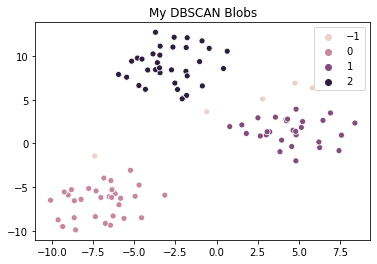

In [12]:
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=clusters)
plt.title("My DBSCAN Blobs")
plt.show()

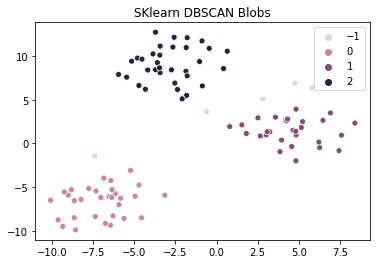

In [13]:
# SKlearn DBSCAN
sns.scatterplot(blobs_X[:,0], blobs_X[:,1], hue=sklearn_clusters.labels_)
plt.title("SKlearn DBSCAN Blobs")
plt.show()